In [5]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline

In [7]:
n_samples=1000000
n_features=10
X, y = make_blobs(n_samples=n_samples, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'])
pddf['id'] = 'row'+pddf.index.astype(str)

In [10]:
pddf

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,id
0,-3.166771,-6.656822,4.487451,-3.026211,-4.027539,2.232245,-7.045234,5.988627,-8.487368,9.334317,row0
1,-9.684210,9.229980,5.946197,-5.576625,-6.846506,-7.607507,-1.898138,0.385057,-1.131365,-5.017755,row1
2,-8.411245,-3.488244,-9.286693,7.545883,-5.168007,3.739833,-6.071231,2.385325,0.827271,-7.046513,row2
3,-3.426842,-4.028318,5.537911,-4.692147,-4.305796,-1.772540,-6.744186,3.940025,-9.321463,10.606296,row3
4,9.066450,6.851678,9.085654,5.846004,2.172495,9.023892,-7.224522,-8.324583,-7.246586,-3.314304,row4
...,...,...,...,...,...,...,...,...,...,...,...
999995,-3.285948,9.046858,4.609713,3.243938,-9.234784,-6.233609,-8.467620,6.517095,2.915124,4.367704,row999995
999996,8.659692,2.995143,-2.541485,-9.426828,-4.570794,-3.448217,2.421931,1.785381,7.893602,-1.164516,row999996
999997,-9.551617,10.520938,6.274131,-5.168869,-6.146470,-7.037458,-4.330949,-0.549023,-1.259285,-3.924337,row999997
999998,7.156811,4.040988,-3.059900,-9.736503,-5.572444,-2.569983,2.234958,4.577705,7.406960,0.262020,row999998


In [11]:
pddf = pddf[['id', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']]

In [13]:
pddf.to_csv('/Users/dengkun/Desktop/598/final project/10dim_data.csv', index=False)

In [14]:
from pyspark.sql import SparkSession  
# spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.appName("Python Spark Data Exploration")\
           .config("spark.some.config.option", "some-value").getOrCreate()

In [15]:
filename = "/Users/dengkun/Desktop/598/final project/10dim_data.csv"
df = spark.read.options(header=True, inferSchema=True).csv(filename)

In [16]:
df.show()

+-----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+
|   id|                 x1|                 x2|                 x3|                 x4|                 x5|                 x6|                  x7|                  x8|                 x9|                x10|
+-----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+
| row0| -3.166770597329104| -6.656821533308467|   4.48745106929225|-3.0262108754962957| -4.027539365764126|  2.232245307379662|  -7.045234210081067|   5.988626864416861| -8.487368215500444|  9.334317066843465|
| row1| -9.684209510990058|  9.229980066898486|  5.946196765844924| -5.576624879331617| -6.846506376638757| -7.607506988755899| -1.8981382687299257|  0.38505722

In [17]:
df_feat = df.select(*(df[c].cast("float").alias(c) for c in df.columns[1:]))
df_feat.show()

+----------+-----------+----------+----------+----------+----------+-----------+------------+-----------+-----------+
|        x1|         x2|        x3|        x4|        x5|        x6|         x7|          x8|         x9|        x10|
+----------+-----------+----------+----------+----------+----------+-----------+------------+-----------+-----------+
|-3.1667707| -6.6568217|  4.487451|-3.0262108|-4.0275393| 2.2322452|  -7.045234|    5.988627|  -8.487369|   9.334317|
|  -9.68421|    9.22998| 5.9461966| -5.576625|-6.8465066|-7.6075068| -1.8981383|  0.38505724| -1.1313645|  -5.017755|
| -8.411244| -3.4882438| -9.286694|  7.545883|-5.1680074| 3.7398324|  -6.071231|   2.3853252|  0.8272706| -7.0465136|
|-3.4268425| -4.0283184| 5.5379105|-4.6921473|-4.3057957|-1.7725397| -6.7441864|   3.9400256|  -9.321463|  10.606297|
|  9.066449|  6.8516784|  9.085654| 5.8460035| 2.1724951|  9.023891|  -7.224522|   -8.324582| -7.2465863| -3.3143036|
| -7.158818|  4.0237536| 3.8506474| 0.1970871|  5.877695

In [18]:
features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']

In [19]:
for col in df.columns:
    if col in features:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+-----+----------+-----------+----------+----------+----------+----------+-----------+------------+-----------+-----------+
|   id|        x1|         x2|        x3|        x4|        x5|        x6|         x7|          x8|         x9|        x10|
+-----+----------+-----------+----------+----------+----------+----------+-----------+------------+-----------+-----------+
| row0|-3.1667707| -6.6568217|  4.487451|-3.0262108|-4.0275393| 2.2322452|  -7.045234|    5.988627|  -8.487369|   9.334317|
| row1|  -9.68421|    9.22998| 5.9461966| -5.576625|-6.8465066|-7.6075068| -1.8981383|  0.38505724| -1.1313645|  -5.017755|
| row2| -8.411244| -3.4882438| -9.286694|  7.545883|-5.1680074| 3.7398324|  -6.071231|   2.3853252|  0.8272706| -7.0465136|
| row3|-3.4268425| -4.0283184| 5.5379105|-4.6921473|-4.3057957|-1.7725397| -6.7441864|   3.9400256|  -9.321463|  10.606297|
| row4|  9.066449|  6.8516784|  9.085654| 5.8460035| 2.1724951|  9.023891|  -7.224522|   -8.324582| -7.2465863| -3.3143036|
| row5| 

In [20]:
vecAssembler = VectorAssembler(inputCols=features, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-3.1667706966400...|
| row1|[-9.6842098236083...|
| row2|[-8.4112443923950...|
| row3|[-3.4268424510955...|
| row4|[9.06644916534423...|
| row5|[-7.1588177680969...|
| row6|[-3.1087625026702...|
| row7|[6.67514467239379...|
| row8|[1.27449309825897...|
| row9|[-3.3172249794006...|
|row10|[-2.2261672019958...|
|row11|[7.81398534774780...|
|row12|[-2.4596991539001...|
|row13|[-1.8338967561721...|
|row14|[1.07918441295623...|
|row15|[-1.7610918283462...|
|row16|[-8.0116167068481...|
|row17|[4.85798597335815...|
|row18|[-5.9378161430358...|
|row19|[-1.7267303466796...|
+-----+--------------------+
only showing top 20 rows



In [21]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [22]:
silhouette = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    silhouette[k] = evaluator.evaluate(predictions)

Text(0,0.5,'silhouette')

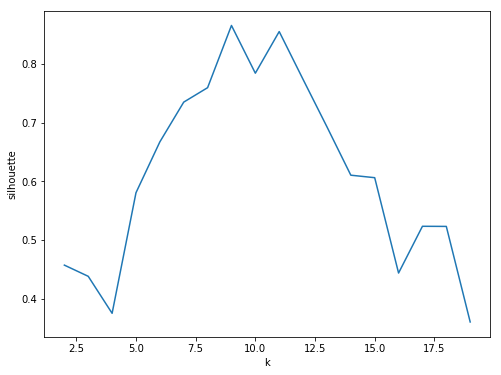

In [23]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette[2:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette')

In [24]:
kmeans = KMeans().setK(9).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
predictions = model.transform(df_kmeans)
evaluator = ClusteringEvaluator()
silhouette[k] = evaluator.evaluate(predictions)

In [25]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 2.14332851 -6.57765001 -8.69121321  8.98550475  9.3157142   6.16800035
 -3.92121984 -8.03985963  3.66850602 -1.19955819]
[-9.58623883  9.38841496  6.64098035 -5.76230542 -6.35230116 -6.34229102
 -3.90811076  0.50248413 -1.35570785 -4.17307294]
[ 9.3992149   5.50553021  8.79615082  7.88553735  1.95953629  8.44294603
 -8.2286448  -6.07735087 -9.09479548 -3.4991002 ]
[ 7.25092585  2.4654827  -3.37523309 -8.73394077 -3.78675174 -3.4923245
  4.59323184  2.74438472  7.75607733 -0.54831631]
[-2.49888046  9.01793405  4.64709909  1.97466447 -6.86596685 -6.87885853
 -8.83743109  7.3131444   2.02777823  4.16501508]
[-2.66616607 -3.65888614 -6.73525349  2.7749826  -2.84412544  4.47554106
 -4.89135097  0.34328021  1.38478608 -7.69425354]
[ 5.44643619 -6.02654085 -9.87863204  6.2918944   4.11262199  4.58712572
  5.4283074  -8.52177984 -2.81630374 -7.68735337]
[-7.61423113  4.25812005  5.23098448  1.23827501  5.4212614  -0.15410869
  0.43478931 -1.44870365 -9.49127797 -7.84771291]

In [26]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id='row0', prediction=8), Row(id='row1', prediction=1), Row(id='row2', prediction=5)]


In [27]:
transformed.show(10)

+----+----------+
|  id|prediction|
+----+----------+
|row0|         8|
|row1|         1|
|row2|         5|
|row3|         8|
|row4|         2|
|row5|         7|
|row6|         8|
|row7|         3|
|row8|         5|
|row9|         4|
+----+----------+
only showing top 10 rows



In [28]:
df_pred = transformed.join(df, 'id')
df_pred.show()

+---------+----------+----------+------------+----------+----------+-----------+-----------+----------+-----------+----------+----------+
|       id|prediction|        x1|          x2|        x3|        x4|         x5|         x6|        x7|         x8|        x9|       x10|
+---------+----------+----------+------------+----------+----------+-----------+-----------+----------+-----------+----------+----------+
|row100093|         5| -7.706476|-0.041760348| -7.642354| 7.7740793| -2.4301698|  3.1249366|-4.6166716|  0.3699733|  0.622481| -6.827555|
|row100200|         8|-1.2829843|  -4.3128405| 5.2398705|-1.3323084| -2.3750305|  0.5926406| -5.734301|    6.61876| -8.910123| 8.9012575|
|row100356|         4|-2.4537423|    11.92727| 3.0797682|  2.645215|   -5.93955| -7.6319265| -10.00788|   6.167714|0.20664999| 5.1303782|
| row10044|         0| 2.5934064|  -6.7016253| -6.374908|  9.361262|  10.167696|   6.544834|-6.0826373|  -8.537234| 3.3962393|-1.4735045|
|row100578|         6|  5.350537| 

In [29]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
id,,,,,,,,,,,
row100093,5,-7.706476,-0.041760,-7.642354,7.774079,-2.430170,3.124937,-4.616672,0.369973,0.622481,-6.827555
row100200,8,-1.282984,-4.312840,5.239871,-1.332308,-2.375031,0.592641,-5.734301,6.618760,-8.910123,8.901258
row100356,4,-2.453742,11.927270,3.079768,2.645215,-5.939550,-7.631927,-10.007880,6.167714,0.206650,5.130378
row10044,0,2.593406,-6.701625,-6.374908,9.361262,10.167696,6.544834,-6.082637,-8.537234,3.396239,-1.473505
row100578,6,5.350537,-6.652949,-9.445839,4.535946,5.552589,4.991347,6.353647,-7.903016,-2.759991,-7.867816
